# 1 Problem formulation
The goal of this project is to predict whether a narrated story is true or false based on 30-second audio recordings, each labeled as "true" or "false." To achieve this, I focus on extracting meaningful features from the audio, preprocessing the data effectively, and training a machine learning model capable of accurate classification.

This problem is challenging due to the variability in tone, pace, and acoustic features across recordings, which requires the model to generalize well to unseen data. Additionally, careful feature extraction (e.g., power, pitch, MFCCs, spectral features) and preprocessing are essential to ensure that important patterns in the storytelling process are captured.

The project has significant real-world implications, such as in forensic linguistics, content moderation, and deception detection. By employing robust techniques for feature extraction, model selection, and evaluation, this project aims to build a reliable solution for classifying true and false stories effectively.

# 2 Methodology

I approached the task of classifying audio recordings as true or fabricated stories through the following steps:

1. Data Preprocessing: I loaded the dataset, standardized audio file paths, and encoded story labels as binary values (1 for true, 0 for false).

2. Audio Chunking: I split each audio file into three 30-second chunks—first, middle, and last—to analyze different parts of the recordings.

3. Feature Extraction: Using librosa, I extracted features such as power, pitch statistics, voiced frame rate, MFCCs, and spectral features for each chunk.

4. Feature Ranking: I ranked features based on their correlation with the story labels to identify the most relevant ones.

5. Model Training: I trained and tested SVM, Logistic Regression, KNN, and Random Forest models, applying sequential feature selection to improve performance. I used stratified K-fold cross-validation for evaluation.

6. Evaluation and Selection: I evaluated models using accuracy, F1-score, and confusion matrices, selecting the model with the best overall balance for the final prediction task.

This process ensured a comprehensive analysis of features and model performance.

# 3 Implemented ML prediction pipelines

In this mini-project, I developed and explored machine learning pipelines to classify whether a narrated story is true or false using 30-second audio clips. The pipeline is designed to process raw audio data, extract meaningful features, train machine learning models, and make predictions effectively.


#### **Overview of the ML Pipeline**
The pipeline consists of the following key stages:
- **Input Stage**: Raw 30-second audio clips serve as the input.
- **Transformation Stage**: The audio data is transformed into feature vectors using feature extraction techniques such as MFCCs, spectral features, pitch-related features, and power.
- **Model Stage**: Machine learning models (SVM, KNN, and Logistic Regression) are trained using the extracted features and their corresponding labels (true or false).
- **Ensemble Stage**: An ensemble approach combines the predictions from multiple models to improve accuracy and robustness.

**Data Flow Through the Pipeline**:
- **Input**: Raw audio files (.wav format).
- **Intermediate**: Feature vectors representing audio characteristics.
- **Output**: Class labels (0 for false, 1 for true) predicted by the trained model.


### **3.1 Transformation Stage**
The transformation stage converts raw audio files into a numerical representation that is suitable for machine learning.

**Steps**:
1. **Loading Audio**: Audio files are loaded using `librosa`.
2. **Chunking**: Each audio file is divided into three 30-second segments (first, middle, and last) to capture variations in storytelling.
3. **Feature Extraction**:
   - **MFCCs**: Capture the spectral envelope of the audio.
   - **Spectral Features**: Include spectral centroid, bandwidth, and rolloff to describe frequency distribution.
   - **Pitch-Related Features**: Mean and standard deviation of pitch, and voiced frame rate.
   - **Power**: RMS energy measures loudness.

**Output**: A DataFrame with rows representing audio chunks and columns containing the extracted features.


### **3.2 Model Stage**
This stage involves training machine learning models to classify the audio data based on the extracted features.

**Models Explored**:
- **Support Vector Machine (SVM)**: Trained with a linear kernel to classify high-dimensional feature data.
- **K-Nearest Neighbors (KNN)**: Uses proximity to training instances for classification.
- **Logistic Regression**: Provides probabilistic binary classification.

**Input and Output**:
- **Input**: Feature vectors (numerical data) and labels (true or false).
- **Output**: Trained models capable of predicting the class label for any audio chunk.


### **3.3 Ensemble Stage**
To enhance classification performance, I combined the predictions of multiple models using an ensemble approach.

**Hard Voting Ensemble**:
1. **Training**: SVM, KNN, and Logistic Regression models were trained on the same data.
2. **Prediction**: Each model produced a class label (true or false) for the test data.
3. **Combining Predictions**: Final predictions were determined by majority voting across the predictions from the individual models.

**Output**: Final predicted labels (true or false) for the test data, leveraging the strengths of all models.


### **Summary**
The pipeline for this project includes the following steps:
1. **Input**: Raw 30-second audio clips.
2. **Transformation**: Audio is segmented and transformed into numerical features (MFCCs, spectral features, pitch-related features, power).
3. **Modeling**: SVM, KNN, and Logistic Regression are trained using these features.
4. **Ensemble**: Predictions from individual models are combined using a hard voting mechanism to improve performance.

By following this pipeline, I aimed to classify narrated stories as true or false based on their audio characteristics, leveraging an ensemble approach to improve generalization and accuracy.


# 4 Dataset


I used the MLEnd Deception Dataset, which includes audio files and metadata with story labels (true/false) and language. To prepare the dataset for modeling, I processed the data as follows:

1. **Original Dataset**: I started with the raw audio files and metadata, which served as the foundation for feature extraction.

2. **Processed Dataset**:
   - I split each audio file into three 30-second chunks (first, middle, last) to capture different parts of the recordings.
   - For each chunk, I extracted features such as MFCCs, spectral features, pitch-related features, and power.
   - I combined these features with the story labels and language attributes to create a structured DataFrame.

3. **Training and Validation Split**:
   - I split the dataset into 80% training and 20% validation sets, ensuring independence by keeping chunks from the same file in a single set.
   - I used stratified splitting to maintain a balanced class distribution in both sets.

4. **Exploration**:
   - I visualized feature distributions and correlation matrices to identify patterns and validate feature relevance.
   - I ensured that true and false labels were balanced in both training and validation sets.

**Limitations**:
- The dataset is small, which might limit model generalization.
- Chunking introduces redundancy, as multiple chunks come from the same audio file.
- Language variability might affect the model's focus on deception-related features.

This preparation ensured that the datasets were ready for robust feature extraction, model training, and evaluation.


# 5 Experiments and results

I installed necessary libraries, downloaded the MLEnd Deception Dataset, loaded metadata, added full file paths, encoded story labels, and saved the updated metadata for further use.

In [ ]:
# Step 1: Install and import necessary libraries
!pip install mlend==1.0.0.4
!pip install librosa==0.10.2.post1
!pip install numpy==1.26.4 scipy==1.13.1 scikit-learn==1.5.2

import os
import pandas as pd
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from mlend import download_deception_small
from tqdm import tqdm
import numpy as np
import joblib

# Step 2: Download the Dataset and Load Metadata
datadir = download_deception_small(save_to='MLEnd', subset={}, verbose=1, overwrite=False)

# Load metadata from the CSV file
csv_path = os.path.join(datadir, "MLEndDD_story_attributes_small.csv")
attributes = pd.read_csv(csv_path)

# Step 3: Add Full File Paths and Encode Labels
audio_base_dir = os.path.join(datadir, "MLEndDD_stories_small")  # Directory containing raw audio files
attributes['file_path'] = attributes['filename'].apply(lambda x: os.path.join(audio_base_dir, x))
attributes['label'] = attributes['Story_type'].apply(lambda x: 1 if x == "true_story" else 0)

# Print metadata overview
print("Metadata loaded from CSV:")
print(attributes.head())

# Save updated metadata for future steps
attributes.to_csv("metadata_with_paths.csv", index=False)
print("Metadata with file paths saved as metadata_with_paths.csv.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 26.2 MB/s eta 0:00:00
  Created wheel for python-picard: filename=python_picard-0.8-py3-none-any.whl size=16394 sha256=f3433edda06b8bd38c66e02bb3cb28fc3a485b0643b1100dd3322676cbf3e44c
  Stored in directory: /root/.cache/pip/wheels/d7/2d/9f/cdbaa870f73d637972241ec2213760c7efb6ac88880a19ba91
Successfully built python-picard


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

  1%|                                                  |100\1|00001.wav

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


100%|▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓|100\100|00100.wav
Done!
Metadata loaded from CSV:
    filename Language       Story_type  \
0  00001.wav    Hindi  deceptive_story   
1  00002.wav  English       true_story   
2  00003.wav  English  deceptive_story   
3  00004.wav  Bengali  deceptive_story   
4  00005.wav  English  deceptive_story   

                                         file_path  label  
0  MLEnd/deception/MLEndDD_stories_small/00001.wav      0  
1  MLEnd/deception/MLEndDD_stories_small/00002.wav      1  
2  MLEnd/deception/MLEndDD_stories_small/00003.wav      0  
3  MLEnd/deception/MLEndDD_stories_small/00004.wav      0  
4  MLEnd/deception/MLEndDD_stories_small/00005.wav      0  
Metadata with file paths saved as metadata_with_paths.csv.


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


I wrote a function to analyze the sampling rates of audio files in the dataset, identified unique sampling rates and their proportions, and confirmed this information to ensure consistency in the audio processing pipeline.

In [ ]:
from collections import Counter
import librosa

def print_sampling_rate_summary(file_paths):
    """
    Identify and print unique sampling rates and the ratio of files with each sampling rate.

    Parameters:
    - file_paths: List of file paths to the audio files.

    Returns:
    - sampling_rate_summary: A Counter object with sampling rates as keys and counts as values.
    """
    sampling_rates = []

    # Load all files and collect their sampling rates
    for file_path in tqdm(file_paths, desc="Checking sampling rates"):
        _, sr = librosa.load(file_path, sr=None)  # Load file with its original sampling rate
        sampling_rates.append(sr)

    # Count occurrences of each sampling rate
    rate_counts = Counter(sampling_rates)

    # Calculate total files
    total_files = sum(rate_counts.values())

    # Print summary
    print("Unique sampling rates:")
    for sr, count in rate_counts.items():
        ratio = (count / total_files) * 100
        print(f"Sampling Rate: {sr} Hz, Count: {count}, Ratio: {ratio:.2f}%")

    return rate_counts

# Calculate sampling rate summary for the dataset
sampling_rate_summary = print_sampling_rate_summary(attributes['file_path'])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Checking sampling rates:   0%|          | 0/100 [00:00<?, ?it/s]<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to 

Unique sampling rates:
Sampling Rate: 44100 Hz, Count: 99, Ratio: 99.00%
Sampling Rate: 48000 Hz, Count: 1, Ratio: 1.00%


I standardized the sampling rate of all audio files to 44,100 Hz to ensure consistency in the dataset, saved the processed files to a new directory, verified their sampling rates, and updated the metadata with the new file paths.

In [ ]:
import os
import librosa
import soundfile as sf
from tqdm import tqdm

def standardize_sampling_rate(file_paths, target_sr=44100, output_dir="standardized_audio"):
    """
    Standardize the sampling rate of all audio files to a target sampling rate.

    Parameters:
    - file_paths: List of file paths to the audio files.
    - target_sr: Target sampling rate (default 44100 Hz).
    - output_dir: Directory to save standardized audio files.

    Returns:
    - standardized_files: List of file paths to the standardized audio files.
    """
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    standardized_files = []

    for file_path in tqdm(file_paths, desc="Standardizing audio files"):
        # Load audio file
        audio, sr = librosa.load(file_path, sr=None)

        # Resample (always resample to ensure consistency)
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

        # Save the standardized audio file
        file_name = os.path.basename(file_path)
        output_file_path = os.path.join(output_dir, file_name)
        sf.write(output_file_path, audio, target_sr)
        standardized_files.append(output_file_path)

    return standardized_files

# Standardize all audio files to 44100 Hz
attributes['file_path'] = standardize_sampling_rate(attributes['file_path'], target_sr=44100)

# Verify that all files are standardized
def verify_sampling_rate(file_paths, target_sr=44100):
    """
    Verify that all audio files are standardized to the target sampling rate.

    Parameters:
    - file_paths: List of file paths to the audio files.
    - target_sr: Target sampling rate.

    Returns:
    - bool: True if all files are standardized, False otherwise.
    """
    for file_path in file_paths:
        _, sr = librosa.load(file_path, sr=None)
        if sr != target_sr:
            print(f"File {file_path} has a sampling rate of {sr}, not {target_sr}.")
            return False
    print("All audio files are standardized to the target sampling rate.")
    return True

# Verify that all files in 'standardized_audio' are at 44100 Hz
is_standardized = verify_sampling_rate(attributes['file_path'])

# Save updated metadata
attributes.to_csv("metadata_with_standardized_paths.csv", index=False)
print("All audio files standardized and verified. Updated metadata saved as 'metadata_with_standardized_paths.csv'.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Standardizing audio files: 100%|██████████| 100/100 [00:41<00:00,  2.38it/s]


All audio files are standardized to the target sampling rate.
All audio files standardized and verified. Updated metadata saved as 'metadata_with_standardized_paths.csv'.


I performed a stratified train-test split to ensure the label proportions were preserved, saved the split metadata into separate CSV files for training and testing, and verified the label distribution in both sets.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the updated metadata
metadata_path = "metadata_with_standardized_paths.csv"
attributes = pd.read_csv(metadata_path)

# Perform stratified train-test split
train_df, test_df = train_test_split(
    attributes,
    test_size=0.2,  # 20% test set
    stratify=attributes['label'],  # Preserve label proportions
    random_state=42  # Ensure reproducibility
)

# Save train and test metadata to CSV files
train_metadata_path = "train_metadata.csv"
test_metadata_path = "test_metadata.csv"
train_df.to_csv(train_metadata_path, index=False)
test_df.to_csv(test_metadata_path, index=False)

# Display the label distribution in train and test sets
print("Training Set Label Distribution:")
print(train_df['label'].value_counts())

print("\nTesting Set Label Distribution:")
print(test_df['label'].value_counts())

print(f"\nTrain and test metadata saved as '{train_metadata_path}' and '{test_metadata_path}' respectively.")


Training Set Label Distribution:
label
0    40
1    40
Name: count, dtype: int64

Testing Set Label Distribution:
label
1    10
0    10
Name: count, dtype: int64

Train and test metadata saved as 'train_metadata.csv' and 'test_metadata.csv' respectively.


I reloaded the metadata and analyzed the distribution of languages in the dataset by counting the occurrences of each language, and then displayed the distribution.

I wanted to answer the following question

Q Does the baseline for detecting truth or deception differ between English and Non-English audio recordings, and if so, should language be considered as a feature in the model?

Looking at the distribution of languages, I can see that the majority of the data is in English. Since the other languages are scarce, it doesn't make sense to compare each one separately with English. The more interesting question, in my opinion, is how non-English languages differ from English.

In [ ]:
# Re-importing necessary libraries after reset
import pandas as pd

# Load the metadata again
metadata_path = "metadata_with_standardized_paths.csv"
attributes = pd.read_csv(metadata_path)

# Analyze language distribution
language_distribution = attributes['Language'].value_counts()

# Display the language distribution
language_distribution


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: 

,count
Language,
English,78
Hindi,4
Arabic,3
"Chinese, Mandarin",2
Marathi,2
Bengali,1
Kannada,1
French,1
Russian,1


Before chunking the audio, I believe it's important for me to first analyze whether language influences the baseline for detecting truth or deception. This helps me understand the impact of language on the classification task at the full audio level, which can guide my decisions during chunking and feature extraction. I grouped the dataset into "English" and "Non-English" based on the language metadata, extracted various audio features with a progress bar, compared feature distributions between the two language groups using boxplots and t-tests, and built a baseline classification model using language as a feature to predict truthfulness, evaluating it with an SVM classifier.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Extracting features:   0%|          | 0/100 [00:00<?, ?it/s]<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find

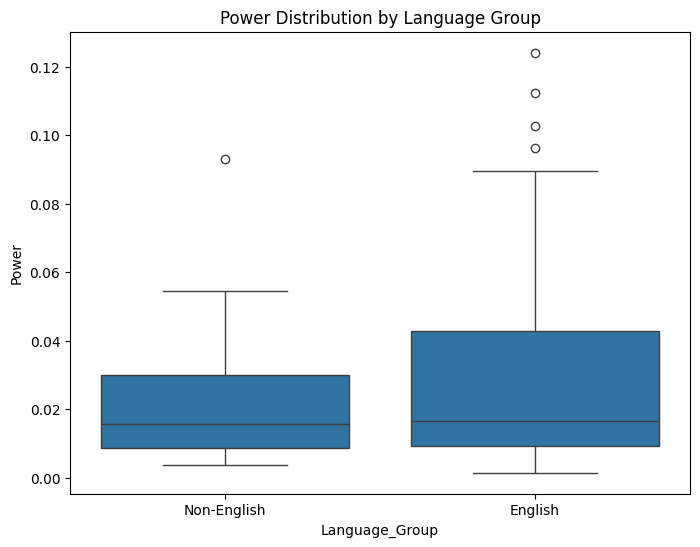

Power: t-stat = 0.8942, p-val = 0.3734


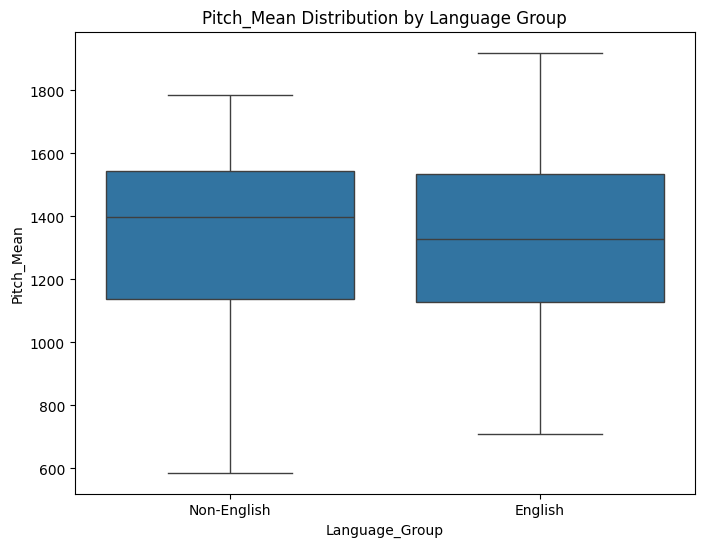

Pitch_Mean: t-stat = 0.3754, p-val = 0.7082


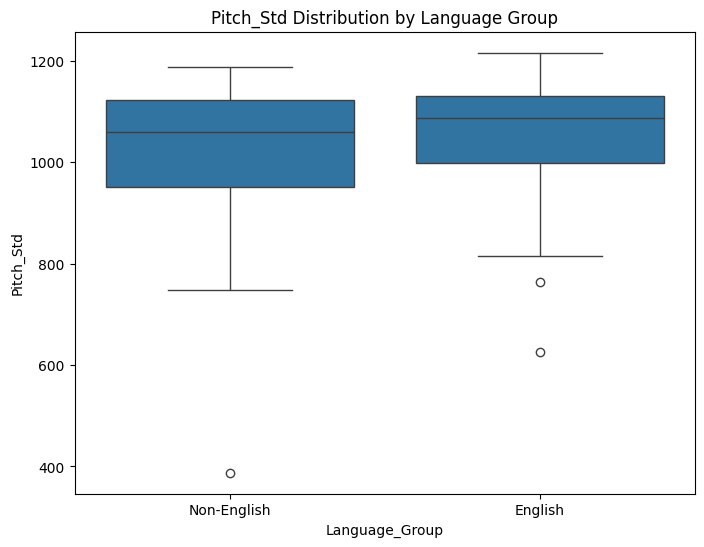

Pitch_Std: t-stat = 1.5042, p-val = 0.1357


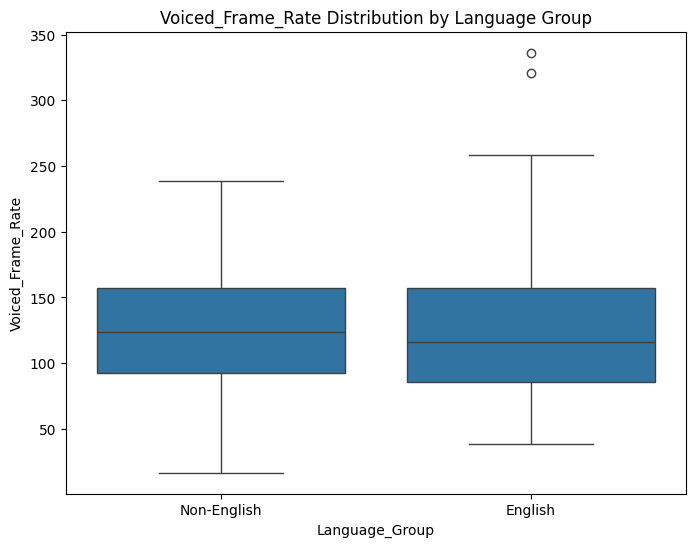

Voiced_Frame_Rate: t-stat = 0.2357, p-val = 0.8142


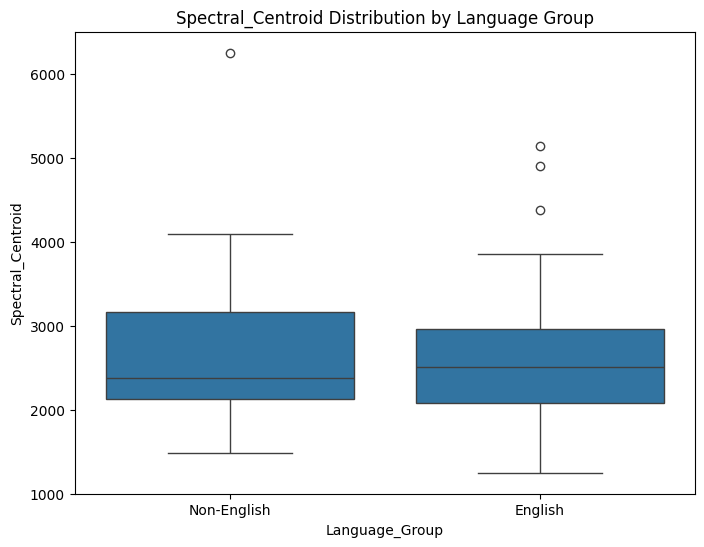

Spectral_Centroid: t-stat = -0.8520, p-val = 0.3963


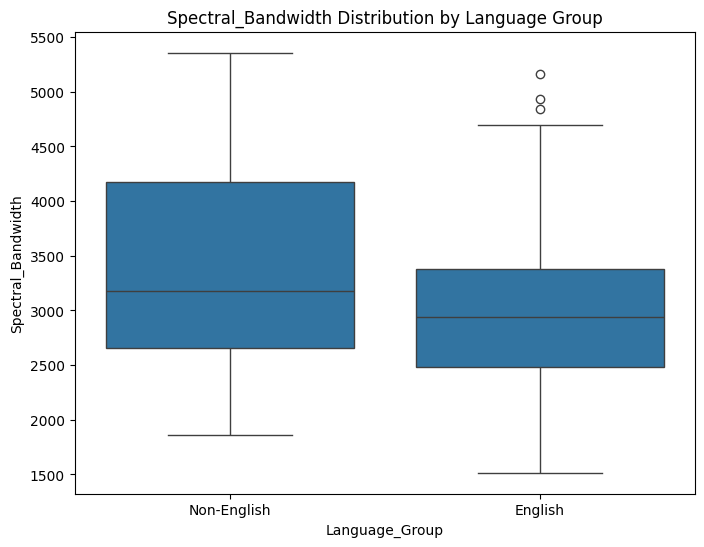

Spectral_Bandwidth: t-stat = -1.8731, p-val = 0.0640


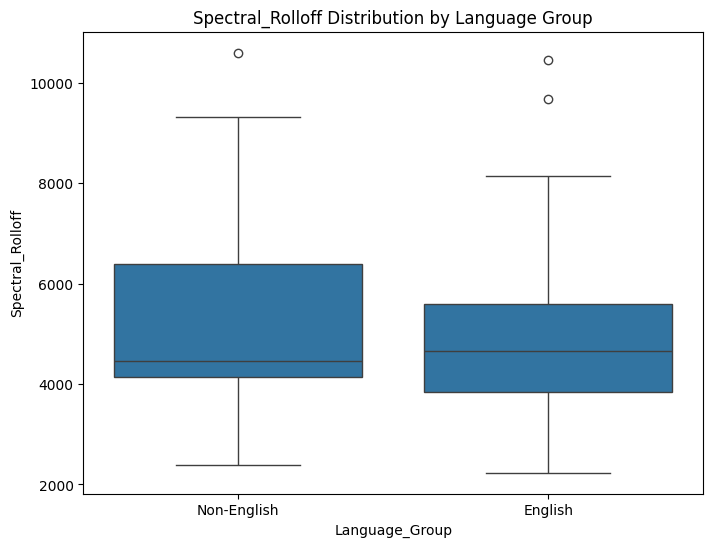

Spectral_Rolloff: t-stat = -1.1108, p-val = 0.2694


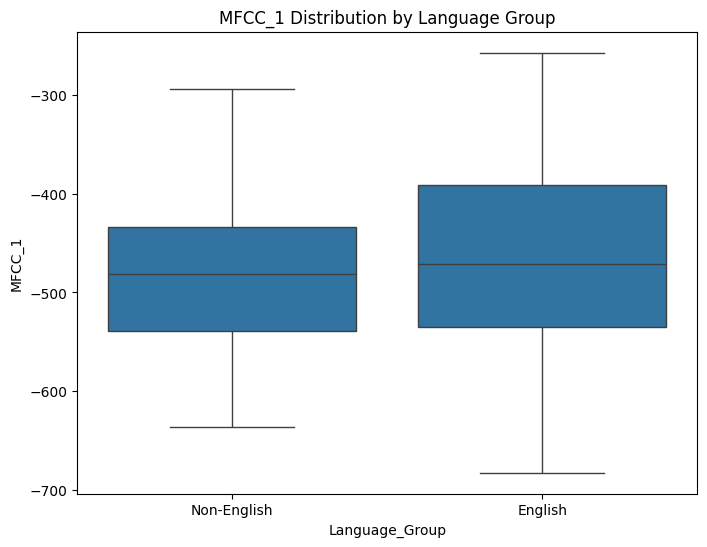

MFCC_1: t-stat = 0.3083, p-val = 0.7585


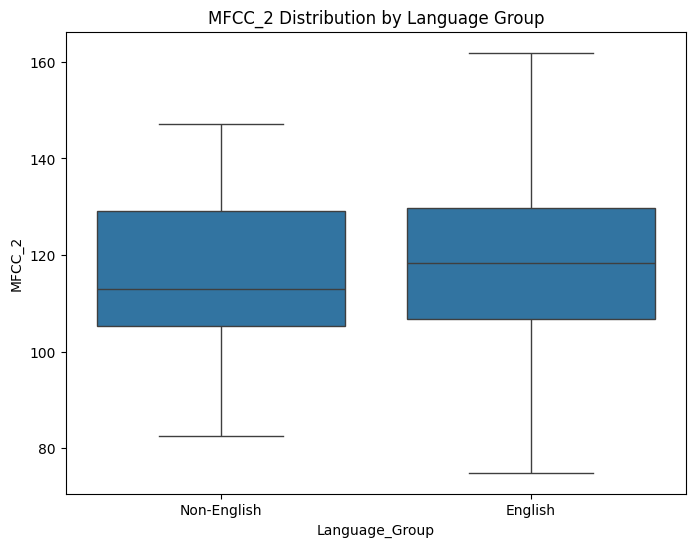

MFCC_2: t-stat = 0.7025, p-val = 0.4841


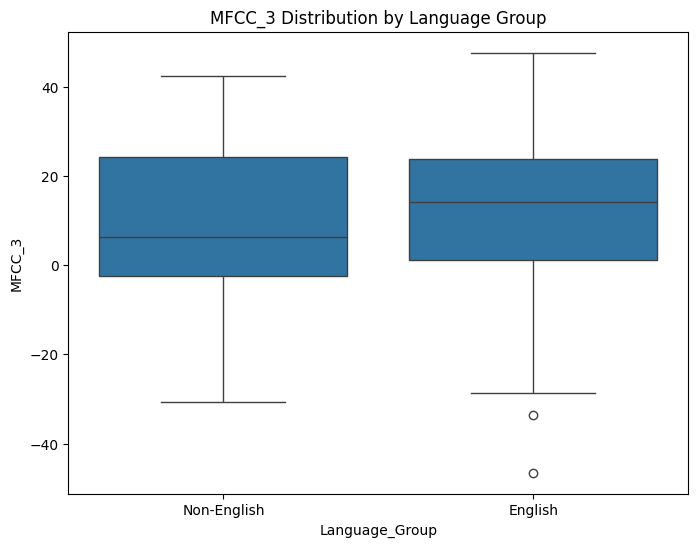

MFCC_3: t-stat = 0.9300, p-val = 0.3546


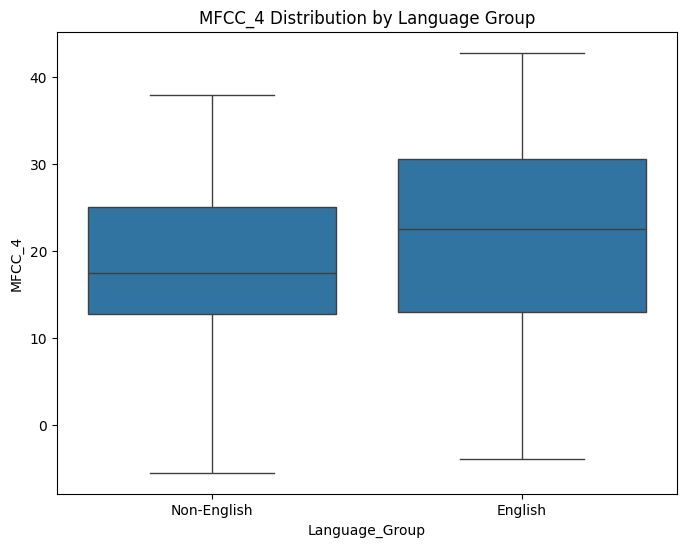

MFCC_4: t-stat = 1.1311, p-val = 0.2608


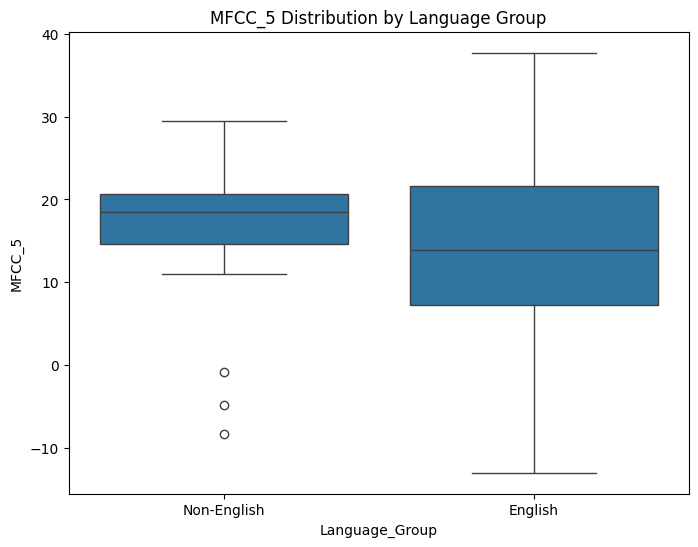

MFCC_5: t-stat = -0.7094, p-val = 0.4797

Baseline Classification Report (Language as Feature):
              precision    recall  f1-score   support

           0       0.20      0.10      0.13        10
           1       0.40      0.60      0.48        10

    accuracy                           0.35        20
   macro avg       0.30      0.35      0.31        20
weighted avg       0.30      0.35      0.31        20

Confusion Matrix:
[[1 9]
 [4 6]]
Accuracy: 0.35


In [ ]:
from tqdm import tqdm
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind

# Step 1: Load metadata and group languages
metadata_path = "metadata_with_standardized_paths.csv"
attributes = pd.read_csv(metadata_path)

# Group into English vs. Non-English
attributes['Language_Group'] = attributes['Language'].apply(lambda x: 'English' if x == 'English' else 'Non-English')

# Step 2: Updated Feature extraction function with progress bar
def extract_features_with_progress(file_paths):
    """
    Extracts audio features with a progress bar:
    - Power
    - Pitch Mean and Std
    - Voiced Frame Rate
    - MFCCs (first 5 coefficients only)
    - Spectral Centroid, Bandwidth, and Rolloff
    """
    features = []

    for file_path in tqdm(file_paths, desc="Extracting features"):
        try:
            audio, sr = librosa.load(file_path, sr=None)

            # Power
            power = np.mean(librosa.feature.rms(y=audio))

            # Pitch
            pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
            valid_pitches = pitches[magnitudes > np.median(magnitudes)]
            pitch_mean = np.mean(valid_pitches) if len(valid_pitches) > 0 else 0
            pitch_std = np.std(valid_pitches) if len(valid_pitches) > 0 else 0

            # Voiced Frame Rate
            voiced_frames = np.sum(magnitudes > np.median(magnitudes))
            total_frames = len(magnitudes)
            voiced_frame_rate = voiced_frames / total_frames if total_frames > 0 else 0

            # MFCCs
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=5)  # Calculate only the first 5 MFCCs
            mfccs_mean = np.mean(mfccs, axis=1)  # Mean of each coefficient

            # Spectral Centroid
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))

            # Spectral Bandwidth
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))

            # Spectral Rolloff
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr, roll_percent=0.85))

            # Combine features
            feature_dict = {
                "file_path": file_path,
                "Power": power,
                "Pitch_Mean": pitch_mean,
                "Pitch_Std": pitch_std,
                "Voiced_Frame_Rate": voiced_frame_rate,
                "Spectral_Centroid": spectral_centroid,
                "Spectral_Bandwidth": spectral_bandwidth,
                "Spectral_Rolloff": spectral_rolloff,
            }

            # Add first 5 MFCCs as individual features
            for i, coeff in enumerate(mfccs_mean):
                feature_dict[f"MFCC_{i+1}"] = coeff

            features.append(feature_dict)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            features.append({"file_path": file_path})

    return pd.DataFrame(features)

# Extract features with progress bar
features_df = extract_features_with_progress(attributes['file_path'])
attributes = pd.concat([attributes, features_df.drop(columns=['file_path'])], axis=1)

# Step 3: Compare feature distributions
feature_columns = [
    'Power', 'Pitch_Mean', 'Pitch_Std', 'Voiced_Frame_Rate',
    'Spectral_Centroid', 'Spectral_Bandwidth', 'Spectral_Rolloff'
] + [f'MFCC_{i+1}' for i in range(5)]  # Use only the first 5 MFCCs

for feature in feature_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=attributes, x='Language_Group', y=feature)
    plt.title(f"{feature} Distribution by Language Group")
    plt.show()

    # Statistical comparison using t-test
    english_values = attributes.loc[attributes['Language_Group'] == 'English', feature]
    non_english_values = attributes.loc[attributes['Language_Group'] == 'Non-English', feature]
    t_stat, p_val = ttest_ind(english_values, non_english_values, nan_policy='omit')
    print(f"{feature}: t-stat = {t_stat:.4f}, p-val = {p_val:.4f}")

# Step 4: Baseline classification with language group as a feature
# Encode language group as binary
attributes['Language_Binary'] = attributes['Language_Group'].apply(lambda x: 1 if x == 'English' else 0)

# Train-test split
X_language = attributes[['Language_Binary']]
y_truth = attributes['label']
X_train_lang, X_test_lang, y_train_truth, y_test_truth = train_test_split(
    X_language, y_truth, test_size=0.2, stratify=y_truth, random_state=42
)

# Train an SVM classifier
lang_clf = SVC(kernel='linear', random_state=42)
lang_clf.fit(X_train_lang, y_train_truth)

# Evaluate the classifier
y_pred_lang = lang_clf.predict(X_test_lang)
print("\nBaseline Classification Report (Language as Feature):")
print(classification_report(y_test_truth, y_pred_lang))
print("Confusion Matrix:")
print(confusion_matrix(y_test_truth, y_pred_lang))
print("Accuracy:", accuracy_score(y_test_truth, y_pred_lang))


What does the results mean?

1. t-value: Shows how different two groups are.

Positive: The first group has a higher mean.

Negative: The first group has a lower mean.

Near 0: Groups are very similar.

2. p-value: Tells if the difference is meaningful or due to chance.

Small p-value (< 0.05): The difference is statistically significant (unlikely due to chance).

Large p-value (> 0.05): The difference is not statistically significant (likely due to chance).

From my analysis, the features Power, Pitch Mean, Pitch Std, and Voiced Frame Rate do not show statistically significant differences between English and Non-English groups. Additionally, the baseline classifier using language group as a feature performed poorly, with accuracy worse than random guessing and low precision, recall, and F1-scores. This indicates that the model struggles to differentiate between truth and deception based solely on language.

Conclusion
While language alone does not seem to meaningfully influence truth or deception detection, it may still play a role when combined with other features. Further exploration is needed to determine its potential contribution.

I wrote functions to extract the first, middle, and last 30-second chunks from audio files, saved them to specified directories, and generated metadata for the chunks, including file paths and labels. Then, I applied these functions to the training and testing datasets, saving the resulting metadata for each chunk type into separate CSV files.

In [ ]:
import os
import librosa
import soundfile as sf
from tqdm import tqdm
import pandas as pd

def select_first_chunk(file_paths, output_dir, chunk_duration=30, sr=44100):
    """
    Extract the first chunk of fixed duration from audio files.

    Parameters:
    - file_paths: List of file paths to the audio files.
    - output_dir: Directory to save the first chunks.
    - chunk_duration: Duration of each chunk in seconds (default 30).
    - sr: Sampling rate (default 44100 Hz).

    Returns:
    - metadata: DataFrame containing paths and labels of the chunked files.
    """
    os.makedirs(output_dir, exist_ok=True)
    metadata = []

    for file_path in tqdm(file_paths, desc="Extracting first chunks"):
        try:
            # Load the audio file
            audio, _ = librosa.load(file_path, sr=sr)

            # Extract the first chunk
            chunk_samples = int(chunk_duration * sr)
            if len(audio) >= chunk_samples:
                first_chunk = audio[:chunk_samples]

                # Save the chunk
                file_name = os.path.basename(file_path)
                chunk_file_name = f"{os.path.splitext(file_name)[0]}_first_chunk.wav"
                chunk_file_path = os.path.join(output_dir, chunk_file_name)
                sf.write(chunk_file_path, first_chunk, sr)

                # Add metadata
                metadata.append({"file_path": chunk_file_path, "label": attributes.loc[attributes['file_path'] == file_path, 'label'].values[0]})
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    return pd.DataFrame(metadata)

def select_last_chunk(file_paths, output_dir, chunk_duration=30, sr=44100):
    """
    Extract the last chunk of fixed duration from audio files.

    Parameters:
    - file_paths: List of file paths to the audio files.
    - output_dir: Directory to save the last chunks.
    - chunk_duration: Duration of each chunk in seconds (default 30).
    - sr: Sampling rate (default 44100 Hz).

    Returns:
    - metadata: DataFrame containing paths and labels of the chunked files.
    """
    os.makedirs(output_dir, exist_ok=True)
    metadata = []

    for file_path in tqdm(file_paths, desc="Extracting last chunks"):
        try:
            # Load the audio file
            audio, _ = librosa.load(file_path, sr=sr)

            # Extract the last chunk
            chunk_samples = int(chunk_duration * sr)
            if len(audio) >= chunk_samples:
                last_chunk = audio[-chunk_samples:]

                # Save the chunk
                file_name = os.path.basename(file_path)
                chunk_file_name = f"{os.path.splitext(file_name)[0]}_last_chunk.wav"
                chunk_file_path = os.path.join(output_dir, chunk_file_name)
                sf.write(chunk_file_path, last_chunk, sr)

                # Add metadata
                metadata.append({"file_path": chunk_file_path, "label": attributes.loc[attributes['file_path'] == file_path, 'label'].values[0]})
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    return pd.DataFrame(metadata)

def select_middle_chunk(file_paths, output_dir, chunk_duration=30, sr=44100):
    """
    Extract the middle chunk of fixed duration from audio files.

    Parameters:
    - file_paths: List of file paths to the audio files.
    - output_dir: Directory to save the middle chunks.
    - chunk_duration: Duration of each chunk in seconds (default 30).
    - sr: Sampling rate (default 44100 Hz).

    Returns:
    - metadata: DataFrame containing paths and labels of the chunked files.
    """
    os.makedirs(output_dir, exist_ok=True)
    metadata = []

    for file_path in tqdm(file_paths, desc="Extracting middle chunks"):
        try:
            # Load the audio file
            audio, _ = librosa.load(file_path, sr=sr)

            # Extract the middle chunk
            chunk_samples = int(chunk_duration * sr)
            total_samples = len(audio)
            if total_samples >= chunk_samples:
                start_sample = (total_samples - chunk_samples) // 2
                middle_chunk = audio[start_sample:start_sample + chunk_samples]

                # Save the chunk
                file_name = os.path.basename(file_path)
                chunk_file_name = f"{os.path.splitext(file_name)[0]}_middle_chunk.wav"
                chunk_file_path = os.path.join(output_dir, chunk_file_name)
                sf.write(chunk_file_path, middle_chunk, sr)

                # Add metadata
                metadata.append({"file_path": chunk_file_path, "label": attributes.loc[attributes['file_path'] == file_path, 'label'].values[0]})
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    return pd.DataFrame(metadata)

# Define output directories
output_dir_first_chunk = "chunked_first"
output_dir_last_chunk = "chunked_last"
output_dir_middle_chunk = "chunked_middle"

# Load train and test metadata
train_metadata_path = "train_metadata.csv"
test_metadata_path = "test_metadata.csv"
train_df = pd.read_csv(train_metadata_path)
test_df = pd.read_csv(test_metadata_path)

# Extract first, middle, and last chunks for train and test sets
train_first_chunk_metadata = select_first_chunk(train_df['file_path'], output_dir_first_chunk)
test_first_chunk_metadata = select_first_chunk(test_df['file_path'], output_dir_first_chunk)

train_middle_chunk_metadata = select_middle_chunk(train_df['file_path'], output_dir_middle_chunk)
test_middle_chunk_metadata = select_middle_chunk(test_df['file_path'], output_dir_middle_chunk)

train_last_chunk_metadata = select_last_chunk(train_df['file_path'], output_dir_last_chunk)
test_last_chunk_metadata = select_last_chunk(test_df['file_path'], output_dir_last_chunk)

# Save metadata for all chunk types
train_first_chunk_metadata.to_csv("train_first_chunk_metadata.csv", index=False)
test_first_chunk_metadata.to_csv("test_first_chunk_metadata.csv", index=False)

train_middle_chunk_metadata.to_csv("train_middle_chunk_metadata.csv", index=False)
test_middle_chunk_metadata.to_csv("test_middle_chunk_metadata.csv", index=False)

train_last_chunk_metadata.to_csv("train_last_chunk_metadata.csv", index=False)
test_last_chunk_metadata.to_csv("test_last_chunk_metadata.csv", index=False)

print("Chunk selection complete. Metadata saved for training and testing datasets.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Extracting last chunks: 100%|██████████| 20/20 [00:01<00:00, 15.18it/s]

Chunk selection complete. Metadata saved for training and testing datasets.


I wrote a function to extract various audio features (e.g., power, pitch, MFCCs, spectral features) from the first, middle, and last chunks of audio files, merged the extracted features with the corresponding labels from the metadata, and saved the resulting datasets for both training and testing into CSV files.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa

def extract_audio_features(file_paths):
    """
    Extract audio features:
    - Power
    - Pitch Mean and Standard Deviation
    - Voiced Frame Rate
    - MFCCs (first 5 coefficients)
    - Spectral Centroid, Bandwidth, and Rolloff

    Parameters:
    - file_paths: List of file paths to the audio files.

    Returns:
    - features_df: DataFrame containing extracted features for each file.
    """
    features = []

    for file_path in tqdm(file_paths, desc="Extracting features from chunks"):
        try:
            # Load the audio file
            audio, sr = librosa.load(file_path, sr=None)

            # Compute Power
            power = np.mean(librosa.feature.rms(y=audio))

            # Compute Pitch Mean and Standard Deviation
            pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
            pitches = pitches[magnitudes > np.median(magnitudes)]  # Filter based on magnitude
            pitch_mean = np.mean(pitches) if len(pitches) > 0 else 0
            pitch_std = np.std(pitches) if len(pitches) > 0 else 0

            # Compute Voiced Frame Rate
            voiced_frames = np.sum(magnitudes > np.median(magnitudes))
            total_frames = len(magnitudes)
            voiced_frame_rate = voiced_frames / total_frames if total_frames > 0 else 0

            # Compute MFCCs (first 5 coefficients)
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=5)
            mfccs_mean = np.mean(mfccs, axis=1)

            # Compute Spectral Features
            spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
            spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
            spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))

            # Store the features
            feature_dict = {
                "file_path": file_path,
                "Power": power,
                "Pitch_Mean": pitch_mean,
                "Pitch_Std": pitch_std,
                "Voiced_Frame_Rate": voiced_frame_rate,
                "Spectral_Centroid": spectral_centroid,
                "Spectral_Bandwidth": spectral_bandwidth,
                "Spectral_Rolloff": spectral_rolloff
            }

            # Add MFCCs to the feature dictionary
            for i, coeff in enumerate(mfccs_mean):
                feature_dict[f"MFCC_{i+1}"] = coeff

            features.append(feature_dict)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")
            # Default values for failed cases
            features.append({
                "file_path": file_path,
                "Power": 0,
                "Pitch_Mean": 0,
                "Pitch_Std": 0,
                "Voiced_Frame_Rate": 0,
                "Spectral_Centroid": 0,
                "Spectral_Bandwidth": 0,
                "Spectral_Rolloff": 0,
                "MFCC_1": 0, "MFCC_2": 0, "MFCC_3": 0, "MFCC_4": 0, "MFCC_5": 0
            })

    return pd.DataFrame(features)

# Load metadata for the three chunks
train_first_metadata = pd.read_csv("train_first_chunk_metadata.csv")
test_first_metadata = pd.read_csv("test_first_chunk_metadata.csv")

train_middle_metadata = pd.read_csv("train_middle_chunk_metadata.csv")
test_middle_metadata = pd.read_csv("test_middle_chunk_metadata.csv")

train_last_metadata = pd.read_csv("train_last_chunk_metadata.csv")
test_last_metadata = pd.read_csv("test_last_chunk_metadata.csv")

# Extract features for first, middle, and last chunks
train_first_chunk_features = extract_audio_features(train_first_metadata['file_path'])
test_first_chunk_features = extract_audio_features(test_first_metadata['file_path'])

train_middle_chunk_features = extract_audio_features(train_middle_metadata['file_path'])
test_middle_chunk_features = extract_audio_features(test_middle_metadata['file_path'])

train_last_chunk_features = extract_audio_features(train_last_metadata['file_path'])
test_last_chunk_features = extract_audio_features(test_last_metadata['file_path'])

# Merge features with labels
train_first_chunk_features = pd.merge(train_first_metadata[['file_path', 'label']],
                                      train_first_chunk_features, on='file_path')
test_first_chunk_features = pd.merge(test_first_metadata[['file_path', 'label']],
                                     test_first_chunk_features, on='file_path')

train_middle_chunk_features = pd.merge(train_middle_metadata[['file_path', 'label']],
                                       train_middle_chunk_features, on='file_path')
test_middle_chunk_features = pd.merge(test_middle_metadata[['file_path', 'label']],
                                      test_middle_chunk_features, on='file_path')

train_last_chunk_features = pd.merge(train_last_metadata[['file_path', 'label']],
                                     train_last_chunk_features, on='file_path')
test_last_chunk_features = pd.merge(test_last_metadata[['file_path', 'label']],
                                    test_last_chunk_features, on='file_path')

# Save extracted features
train_first_chunk_features.to_csv("train_first_chunk_features.csv", index=False)
test_first_chunk_features.to_csv("test_first_chunk_features.csv", index=False)

train_middle_chunk_features.to_csv("train_middle_chunk_features.csv", index=False)
test_middle_chunk_features.to_csv("test_middle_chunk_features.csv", index=False)

train_last_chunk_features.to_csv("train_last_chunk_features.csv", index=False)
test_last_chunk_features.to_csv("test_last_chunk_features.csv", index=False)

print("Feature extraction complete for all chunks. Features with labels saved for training and testing datasets.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
Extracting features from chunks: 100%|██████████| 20/20 [00:14<00:00,  1.33it/s]

Feature extraction complete for all chunks. Features with labels saved for training and testing datasets.


I created a function to evaluate the features from the first, middle, and last audio chunks by training an SVM model on the extracted features, predicting the truthfulness of the stories, and then printing the classification report, confusion matrix, and accuracy for each chunk type.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_chunk_features(train_file, test_file, chunk_name):
    """
    Evaluate features from a specific chunk (first, middle, last).

    Parameters:
    - train_file: Path to the train features CSV.
    - test_file: Path to the test features CSV.
    - chunk_name: Name of the chunk type being evaluated.

    Returns:
    - None (prints evaluation results).
    """
    print(f"\n--- Evaluating {chunk_name} Chunk Features ---")

    # Load train and test datasets
    train_features = pd.read_csv(train_file)
    test_features = pd.read_csv(test_file)

    # Separate features and labels
    X_train = train_features.drop(columns=["file_path", "label"])
    y_train = train_features["label"]

    X_test = test_features.drop(columns=["file_path", "label"])
    y_test = test_features["label"]

    # Train an SVM model
    model = SVC(kernel='linear', random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))

# Evaluate the first chunk
evaluate_chunk_features(
    train_file="train_first_chunk_features.csv",
    test_file="test_first_chunk_features.csv",
    chunk_name="First"
)

# Evaluate the middle chunk
evaluate_chunk_features(
    train_file="train_middle_chunk_features.csv",
    test_file="test_middle_chunk_features.csv",
    chunk_name="Middle"
)

# Evaluate the last chunk
evaluate_chunk_features(
    train_file="train_last_chunk_features.csv",
    test_file="test_last_chunk_features.csv",
    chunk_name="Last"
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



--- Evaluating First Chunk Features ---

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.42      0.50      0.45        10

    accuracy                           0.40        20
   macro avg       0.40      0.40      0.39        20
weighted avg       0.40      0.40      0.39        20


Confusion Matrix:
[[3 7]
 [5 5]]
Accuracy: 0.4

--- Evaluating Middle Chunk Features ---

Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.42      0.50      0.45        10

    accuracy                           0.40        20
   macro avg       0.40      0.40      0.39        20
weighted avg       0.40      0.40      0.39        20


Confusion Matrix:
[[3 7]
 [5 5]]
Accuracy: 0.4

--- Evaluating Last Chunk Features ---

Classification Report:
              precision    recall  f1-score   support



I performed a grid search with cross-validation to find the optimal number of neighbors (n_neighbors) for the K-Nearest Neighbors (KNN) model, using the training data from the first chunk features. I then printed the best value for n_neighbors and the corresponding cross-validation accuracy.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Load your training dataset
train_features = pd.read_csv("train_first_chunk_features.csv")

# Separate features and labels
X_train = train_features.drop(columns=["file_path", "label"])
y_train = train_features["label"]

# Define parameter grid
param_grid = {'n_neighbors': [3, 5, 7, 9]}

# Initialize KNN model
knn = KNeighborsClassifier()

# Perform grid search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameter
print(f"Best n_neighbors: {grid_search.best_params_['n_neighbors']}")
print(f"Best CV accuracy: {grid_search.best_score_:.2f}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: 

Best n_neighbors: 5
Best CV accuracy: 0.51


I wrote a function to evaluate the performance of multiple models (SVM, Logistic Regression, KNN) on features extracted from the first, middle, and last chunks of audio. The function allows for optional feature normalization, and it prints training and testing accuracy, as well as classification reports for each model. I then evaluated the models on both normalized and non-normalized features for each chunk type (first, middle, last).

The evaluation results showed that KNN consistently performed better across all chunk types, with the highest test accuracy of 0.55 for the last chunk. SVM and Logistic Regression performed poorly, with test accuracies around 0.40 to 0.50. Normalization did not significantly improve results for most models, though it helped KNN's performance on the last chunk. Overall, the models had low test set performance, indicating the need for further improvements.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_chunk_features_with_models(train_file, test_file, chunk_name, normalize=False):
    """
    Evaluate features from a specific chunk (first, middle, last) using multiple models.

    Parameters:
    - train_file: Path to the train features CSV.
    - test_file: Path to the test features CSV.
    - chunk_name: Name of the chunk type being evaluated.
    - normalize: Whether to normalize the features.

    Returns:
    - None (prints evaluation results).
    """
    print(f"\n--- Evaluating {chunk_name} Chunk Features {'with Normalization' if normalize else 'without Normalization'} ---")

    # Load train and test datasets
    train_features = pd.read_csv(train_file)
    test_features = pd.read_csv(test_file)

    # Separate features and labels
    X_train = train_features.drop(columns=["file_path", "label"]).values
    y_train = train_features["label"].values

    X_test = test_features.drop(columns=["file_path", "label"]).values
    y_test = test_features["label"].values

    # Normalize features if required
    if normalize:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Define models to evaluate
    models = {
        "SVM": SVC(kernel="linear", random_state=42),
        "Logistic Regression": LogisticRegression(random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }

    # Evaluate each model
    for name, model in models.items():
        print(f"\n--- {name} ---")
        # Train the model
        model.fit(X_train, y_train)

        # Evaluate on training set
        y_train_pred = model.predict(X_train)
        train_acc = accuracy_score(y_train, y_train_pred)
        print(f"\nTrain Metrics:")
        print(f"Accuracy: {train_acc:.2f}")
        print(classification_report(y_train, y_train_pred))

        # Evaluate on testing set
        y_test_pred = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_test_pred)
        print(f"\nTest Metrics:")
        print(f"Accuracy: {test_acc:.2f}")
        print(classification_report(y_test, y_test_pred))


# Evaluate the first chunk
evaluate_chunk_features_with_models(
    train_file="train_first_chunk_features.csv",
    test_file="test_first_chunk_features.csv",
    chunk_name="First",
    normalize=False
)
evaluate_chunk_features_with_models(
    train_file="train_first_chunk_features.csv",
    test_file="test_first_chunk_features.csv",
    chunk_name="First",
    normalize=True
)

# Evaluate the middle chunk
evaluate_chunk_features_with_models(
    train_file="train_middle_chunk_features.csv",
    test_file="test_middle_chunk_features.csv",
    chunk_name="Middle",
    normalize=False
)
evaluate_chunk_features_with_models(
    train_file="train_middle_chunk_features.csv",
    test_file="test_middle_chunk_features.csv",
    chunk_name="Middle",
    normalize=True
)

# Evaluate the last chunk
evaluate_chunk_features_with_models(
    train_file="train_last_chunk_features.csv",
    test_file="test_last_chunk_features.csv",
    chunk_name="Last",
    normalize=False
)
evaluate_chunk_features_with_models(
    train_file="train_last_chunk_features.csv",
    test_file="test_last_chunk_features.csv",
    chunk_name="Last",
    normalize=True
)



--- Evaluating First Chunk Features without Normalization ---

--- SVM ---


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Train Metrics:
Accuracy: 0.55
              precision    recall  f1-score   support

           0       0.57      0.42      0.49        40
           1       0.54      0.68      0.60        40

    accuracy                           0.55        80
   macro avg       0.55      0.55      0.54        80
weighted avg       0.55      0.55      0.54        80


Test Metrics:
Accuracy: 0.40
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.42      0.50      0.45        10

    accuracy                           0.40        20
   macro avg       0.40      0.40      0.39        20
weighted avg       0.40      0.40      0.39        20


--- Logistic Regression ---

Train Metrics:
Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.56      0.55      0.56        40
           1       0.56      0.57      0.57        40

    accuracy                           0.56        80
   macr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



--- SVM ---

Train Metrics:
Accuracy: 0.68
              precision    recall  f1-score   support

           0       0.71      0.60      0.65        40
           1       0.65      0.75      0.70        40

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.67        80
weighted avg       0.68      0.68      0.67        80


Test Metrics:
Accuracy: 0.40
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        10
           1       0.42      0.50      0.45        10

    accuracy                           0.40        20
   macro avg       0.40      0.40      0.39        20
weighted avg       0.40      0.40      0.39        20


--- Logistic Regression ---

Train Metrics:
Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.58      0.55      0.56        40
           1       0.57      0.60      0.59        40

    accuracy                           0.57     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Train Metrics:
Accuracy: 0.56
              precision    recall  f1-score   support

           0       0.56      0.57      0.57        40
           1       0.56      0.55      0.56        40

    accuracy                           0.56        80
   macro avg       0.56      0.56      0.56        80
weighted avg       0.56      0.56      0.56        80


Test Metrics:
Accuracy: 0.40
              precision    recall  f1-score   support

           0       0.40      0.40      0.40        10
           1       0.40      0.40      0.40        10

    accuracy                           0.40        20
   macro avg       0.40      0.40      0.40        20
weighted avg       0.40      0.40      0.40        20


--- Logistic Regression ---

Train Metrics:
Accuracy: 0.64
              precision    recall  f1-score   support

           0       0.64      0.62      0.63        40
           1       0.63      0.65      0.64        40

    accuracy                           0.64        80
   macr

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


I combined the training data from the first, middle, and last chunks, calculated the correlation between each feature and the label, and ranked the features by their absolute correlation values. I then displayed the ranked features and saved the results into a CSV file for further analysis.

I analyzed the correlation between features and labels, ranking them based on their absolute correlation values. The features with the strongest correlations were Power and MFCC_1, which showed the highest relationships with the label. Other features, such as MFCC_3, Spectral_Rolloff, and Voiced_Frame_Rate, had relatively weaker correlations. Overall, Power and MFCC_1 emerged as the most influential features for predicting the truthfulness of the audio, while other features like spectral and pitch-related attributes showed less impact.

In [ ]:
import pandas as pd

# Load training data for all chunks
chunk_files = ["train_first_chunk_features.csv",
               "train_middle_chunk_features.csv",
               "train_last_chunk_features.csv"]

# Combine data from all chunks
combined_data = pd.concat([pd.read_csv(file) for file in chunk_files])

# Separate features and labels
features = combined_data.drop(columns=["file_path", "label"])
labels = combined_data["label"]

# Calculate correlation
correlation_matrix = features.corrwith(labels)

# Rank features by correlation
correlation_df = correlation_matrix.sort_values(ascending=False).reset_index()
correlation_df.columns = ["Feature", "Correlation"]
correlation_df["Absolute_Correlation"] = correlation_df["Correlation"].abs()
correlation_df = correlation_df.sort_values(by="Absolute_Correlation", ascending=False)

# Display ranked features
print("Ranked Features by Correlation:")
print(correlation_df)

# Save results
correlation_df.to_csv("feature_correlations.csv", index=False)


Ranked Features by Correlation:
               Feature  Correlation  Absolute_Correlation
11               Power    -0.230122              0.230122
10              MFCC_1    -0.222864              0.222864
0               MFCC_3     0.095576              0.095576
1               MFCC_2     0.074049              0.074049
2               MFCC_4     0.071650              0.071650
3               MFCC_5     0.069997              0.069997
4     Spectral_Rolloff     0.049103              0.049103
9    Voiced_Frame_Rate    -0.041819              0.041819
5    Spectral_Centroid     0.032914              0.032914
6            Pitch_Std     0.026825              0.026825
8           Pitch_Mean    -0.023435              0.023435
7   Spectral_Bandwidth     0.013855              0.013855


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



I wrote a function to select the top features from the training and testing datasets, based on the features identified as most correlated with the label. I then applied this function to the first, middle, and last chunks, preparing separate datasets for each chunk type with the selected top features: Power, MFCC_1, MFCC_3, and MFCC_2. This allowed me to focus on the most important features for further analysis and model training.

In [ ]:
import pandas as pd

def select_top_features(train_file, test_file, top_features):
    """
    Select the top features from the dataset.

    Parameters:
    - train_file: Path to the train dataset CSV file.
    - test_file: Path to the test dataset CSV file.
    - top_features: List of top features to select.

    Returns:
    - X_train: DataFrame with selected features for training.
    - X_test: DataFrame with selected features for testing.
    - y_train: Series of labels for training.
    - y_test: Series of labels for testing.
    """
    # Load the datasets
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # Separate features and labels
    X_train = train_data[top_features]
    y_train = train_data["label"]

    X_test = test_data[top_features]
    y_test = test_data["label"]

    return X_train, X_test, y_train, y_test

# Define the top features to select
top_features = ["Power", "MFCC_1", "MFCC_3", "MFCC_2"]

# Prepare datasets for first chunk
print("\n--- Preparing Datasets for First Chunk ---")
X_train_first, X_test_first, y_train_first, y_test_first = select_top_features(
    train_file="train_first_chunk_features.csv",
    test_file="test_first_chunk_features.csv",
    top_features=top_features
)

# Prepare datasets for middle chunk
print("\n--- Preparing Datasets for Middle Chunk ---")
X_train_middle, X_test_middle, y_train_middle, y_test_middle = select_top_features(
    train_file="train_middle_chunk_features.csv",
    test_file="test_middle_chunk_features.csv",
    top_features=top_features
)

# Prepare datasets for last chunk
print("\n--- Preparing Datasets for Last Chunk ---")
X_train_last, X_test_last, y_train_last, y_test_last = select_top_features(
    train_file="train_last_chunk_features.csv",
    test_file="test_last_chunk_features.csv",
    top_features=top_features
)

print("Datasets with top features prepared for all chunks.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



--- Preparing Datasets for First Chunk ---

--- Preparing Datasets for Middle Chunk ---

--- Preparing Datasets for Last Chunk ---
Datasets with top features prepared for all chunks.


I wrote a function to train and evaluate SVM, Logistic Regression, and KNN models on the first, middle, and last chunk features, both with and without normalization. The function loads the datasets, applies normalization (if required), trains each model, and then evaluates it on both training and testing data. It prints the accuracy, classification report, and confusion matrix for each model, comparing performance before and after normalization across all chunk types.

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def evaluate_models_with_normalization(train_file, test_file, chunk_name):
    """
    Train and evaluate SVM, Logistic Regression, and KNN before and after normalization.
    """
    # Load datasets
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # Separate features and labels
    X_train = train_data[["Power", "MFCC_1", "MFCC_3", "MFCC_2"]].values
    y_train = train_data["label"].values

    X_test = test_data[["Power", "MFCC_1", "MFCC_3", "MFCC_2"]].values
    y_test = test_data["label"].values

    # Models to evaluate
    models = {
        "SVM": SVC(kernel="linear", random_state=42),
        "Logistic Regression": LogisticRegression(random_state=42),
        "KNN": KNeighborsClassifier(n_neighbors=5)
    }

    # Evaluate models before and after normalization
    for normalize in [False, True]:
        print(f"\n--- {chunk_name} Chunk {'with Normalization' if normalize else 'without Normalization'} ---")

        # Apply normalization if required
        if normalize:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        else:
            X_train_scaled = X_train
            X_test_scaled = X_test

        # Train and evaluate each model
        for model_name, model in models.items():
            print(f"\nModel: {model_name}")
            # Train model
            model.fit(X_train_scaled, y_train)

            # Evaluate on training data
            y_train_pred = model.predict(X_train_scaled)
            train_acc = accuracy_score(y_train, y_train_pred)
            print("\nTrain Metrics:")
            print(f"Accuracy: {train_acc:.2f}")
            print(classification_report(y_train, y_train_pred))

            # Evaluate on testing data
            y_test_pred = model.predict(X_test_scaled)
            test_acc = accuracy_score(y_test, y_test_pred)
            print("\nTest Metrics:")
            print(f"Accuracy: {test_acc:.2f}")
            print(classification_report(y_test, y_test_pred))

# Evaluate for each chunk type
evaluate_models_with_normalization(
    train_file="train_first_chunk_features.csv",
    test_file="test_first_chunk_features.csv",
    chunk_name="First"
)

evaluate_models_with_normalization(
    train_file="train_middle_chunk_features.csv",
    test_file="test_middle_chunk_features.csv",
    chunk_name="Middle"
)

evaluate_models_with_normalization(
    train_file="train_last_chunk_features.csv",
    test_file="test_last_chunk_features.csv",
    chunk_name="Last"
)



--- First Chunk without Normalization ---

Model: SVM

Train Metrics:
Accuracy: 0.57
              precision    recall  f1-score   support

           0       0.62      0.40      0.48        40
           1       0.56      0.75      0.64        40

    accuracy                           0.57        80
   macro avg       0.59      0.57      0.56        80
weighted avg       0.59      0.57      0.56        80


Test Metrics:
Accuracy: 0.45
              precision    recall  f1-score   support

           0       0.43      0.30      0.35        10
           1       0.46      0.60      0.52        10

    accuracy                           0.45        20
   macro avg       0.45      0.45      0.44        20
weighted avg       0.45      0.45      0.44        20


Model: Logistic Regression

Train Metrics:
Accuracy: 0.53
              precision    recall  f1-score   support

           0       0.53      0.50      0.51        40
           1       0.52      0.55      0.54        40

    acc

Effect of Normalization:
I noticed that normalization improved training accuracy for SVM and Logistic Regression, as these models benefit from comparable feature scales. For KNN, normalization had a smaller impact, sometimes slightly improving results. On the test set, normalization helped stabilize SVM's performance, especially for recall and F1-scores. However, for KNN, test accuracy varied, and normalization sometimes reduced its performance.

Chunk Type Comparison:
The Middle Chunk consistently performed better, particularly with KNN, achieving up to 60% test accuracy. First and Last Chunks showed mixed results, with slightly lower or similar performance compared to the Middle Chunk.

Model Comparison:
SVM showed consistent performance across all setups, with test accuracy ranging from 35% to 45%, benefiting from normalization. Logistic Regression followed similar trends but with slightly lower accuracy, around 30-40%. KNN performed best in several scenarios, achieving up to 60% test accuracy, particularly with the Middle Chunk after normalization.

Hyperparameter Tuning for SVM and KNN


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Load the Middle Chunk dataset
train_data = pd.read_csv("train_middle_chunk_features.csv")
test_data = pd.read_csv("test_middle_chunk_features.csv")

X_train = train_data[["Power", "MFCC_1", "MFCC_3", "MFCC_2"]].values
y_train = train_data["label"].values

# Define parameter grid for SVM
svm_param_grid = {
    "C": [0.1, 1, 10],
    "kernel": ["linear", "rbf"],
    "gamma": ["scale", "auto"]  # Only applicable for non-linear kernels
}

# Grid search for SVM
svm = SVC(random_state=42)
svm_grid = GridSearchCV(svm, param_grid=svm_param_grid, cv=5, scoring="accuracy", verbose=1)
svm_grid.fit(X_train, y_train)

# Best parameters for SVM
print("Best SVM Parameters:", svm_grid.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best SVM Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define parameter grid for KNN
knn_param_grid = {
    "n_neighbors": [3, 5, 7, 9],
    "weights": ["uniform", "distance"]
}

# Grid search for KNN
knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid=knn_param_grid, cv=5, scoring="accuracy", verbose=1)
knn_grid.fit(X_train, y_train)

# Best parameters for KNN
print("Best KNN Parameters:", knn_grid.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best KNN Parameters: {'n_neighbors': 3, 'weights': 'uniform'}


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


Retraining and Evaluation

I retrain the models with the best hyperparameters because hyperparameter tuning, like with GridSearchCV, evaluates models using cross-validation on the training data. The best model from this process isn’t trained on the entire training set but on the subsets used during cross-validation. By retraining, I ensure the models fully utilize all the training data with the optimal parameters.

This step allows me to fairly evaluate how well the tuned models generalize to unseen test data, ensuring consistent and reliable metrics for both training and testing. It’s a necessary step to confirm the models are performing at their best before moving forward with ensemble implementation.

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Use best parameters to retrain SVM and KNN
best_svm = SVC(**svm_grid.best_params_, random_state=42)
best_svm.fit(X_train, y_train)

best_knn = KNeighborsClassifier(**knn_grid.best_params_)
best_knn.fit(X_train, y_train)

# Evaluate on test data
X_test = test_data[["Power", "MFCC_1", "MFCC_3", "MFCC_2"]].values
y_test = test_data["label"].values

# SVM Evaluation
y_pred_svm = best_svm.predict(X_test)
print("\nSVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
print("SVM Test Accuracy:", accuracy_score(y_test, y_pred_svm))

# KNN Evaluation
y_pred_knn = best_knn.predict(X_test)
print("\nKNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Test Accuracy:", accuracy_score(y_test, y_pred_knn))



SVM Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.20      0.22        10
           1       0.33      0.40      0.36        10

    accuracy                           0.30        20
   macro avg       0.29      0.30      0.29        20
weighted avg       0.29      0.30      0.29        20

SVM Test Accuracy: 0.3

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.75      0.30      0.43        10

    accuracy                           0.60        20
   macro avg       0.66      0.60      0.56        20
weighted avg       0.66      0.60      0.56        20

KNN Test Accuracy: 0.6


**Hard voting**

I chose hard voting because it is simpler and combines the strengths of our models by relying on their class predictions rather than probabilities. This approach works well when the models are diverse and individually strong, like our KNN and SVM, and it avoids unnecessary complexity while achieving reliable results.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, accuracy_score

# Define the ensemble using KNN and SVM
ensemble = VotingClassifier(
    estimators=[
        ("svm", best_svm),  # Best-performing SVM model
        ("knn", best_knn)   # Best-performing KNN model
    ],
    voting="hard"  # Hard voting since SVM doesn't support predict_proba by default
)

# Train the ensemble
ensemble.fit(X_train, y_train)

# Evaluate the ensemble on the test set
y_pred_ensemble = ensemble.predict(X_test)
print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_pred_ensemble))
print("Ensemble Test Accuracy:", accuracy_score(y_test, y_pred_ensemble))



Ensemble Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.75      0.30      0.43        10

    accuracy                           0.60        20
   macro avg       0.66      0.60      0.56        20
weighted avg       0.66      0.60      0.56        20

Ensemble Test Accuracy: 0.6


I evaluated the ensemble (KNN + SVM with hard voting) across the First, Middle, and Last chunks. Here are the results:

In [ ]:
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load datasets for each chunk
chunk_files = {
    "First": ("train_first_chunk_features.csv", "test_first_chunk_features.csv"),
    "Middle": ("train_middle_chunk_features.csv", "test_middle_chunk_features.csv"),
    "Last": ("train_last_chunk_features.csv", "test_last_chunk_features.csv")
}

# Best parameters from previous tuning (placeholders, update with actual values)
best_svm_params = {"kernel": "linear", "C": 1}
best_knn_params = {"n_neighbors": 5, "weights": "uniform"}

# Initialize models with best parameters
best_svm = SVC(**best_svm_params, random_state=42)
best_knn = KNeighborsClassifier(**best_knn_params)

# Function to evaluate ensemble for each chunk
def evaluate_ensemble(chunk_name, train_file, test_file):
    print(f"\n--- Evaluating Ensemble for {chunk_name} Chunk ---")

    # Load data
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)

    # Separate features and labels
    X_train = train_data[["Power", "MFCC_1", "MFCC_3", "MFCC_2"]].values
    y_train = train_data["label"].values
    X_test = test_data[["Power", "MFCC_1", "MFCC_3", "MFCC_2"]].values
    y_test = test_data["label"].values

    # Create and train ensemble
    ensemble = VotingClassifier(
        estimators=[("svm", best_svm), ("knn", best_knn)],
        voting="hard"
    )
    ensemble.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = ensemble.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy: {accuracy:.2f}")
    print(classification_report(y_test, y_pred))
    return chunk_name, accuracy

# Evaluate ensemble across chunks and collect results
results = []
for chunk_name, (train_file, test_file) in chunk_files.items():
    result = evaluate_ensemble(chunk_name, train_file, test_file)
    results.append(result)

# Save results to a DataFrame for visualization
results_df = pd.DataFrame(results, columns=["Chunk", "Test Accuracy"])
results_df.to_csv("ensemble_chunk_results.csv", index=False)
results_df



--- Evaluating Ensemble for First Chunk ---

Test Accuracy: 0.50
              precision    recall  f1-score   support

           0       0.50      0.80      0.62        10
           1       0.50      0.20      0.29        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.45        20
weighted avg       0.50      0.50      0.45        20


--- Evaluating Ensemble for Middle Chunk ---

Test Accuracy: 0.60
              precision    recall  f1-score   support

           0       0.56      0.90      0.69        10
           1       0.75      0.30      0.43        10

    accuracy                           0.60        20
   macro avg       0.66      0.60      0.56        20
weighted avg       0.66      0.60      0.56        20


--- Evaluating Ensemble for Last Chunk ---

Test Accuracy: 0.45
              precision    recall  f1-score   support

           0       0.46      0.60      0.52        10
           1       0.43      0.30      

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


,Chunk,Test Accuracy
0,First,0.50
1,Middle,0.60
2,Last,0.45


I observed that the Middle Chunk performed the best, achieving a 60% test accuracy, which suggests it might be more informative or representative for this classification task. The First Chunk showed moderate performance but struggled with recall for class 1 (false stories). Meanwhile, the Last Chunk had the lowest performance, with low recall for both classes.

<ipython-input-22-fcfd40f802de>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



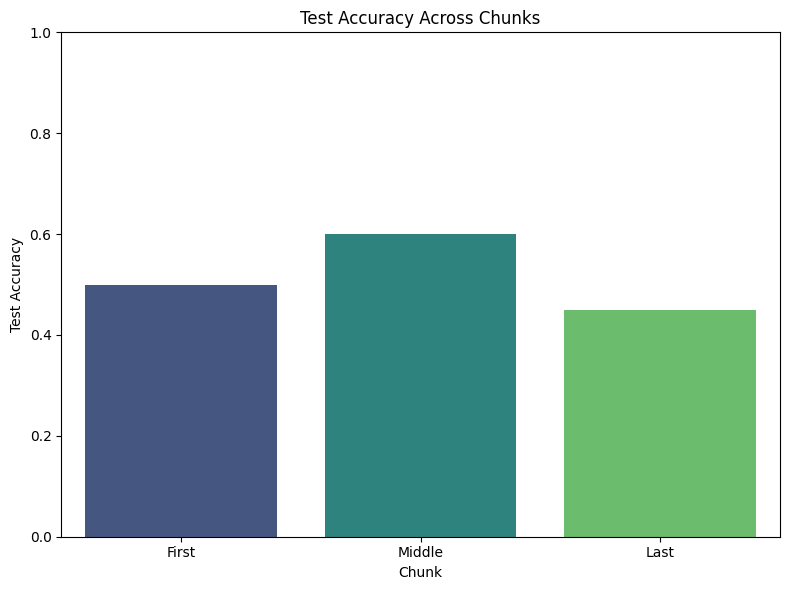

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but SVC was fitted without feature names
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names


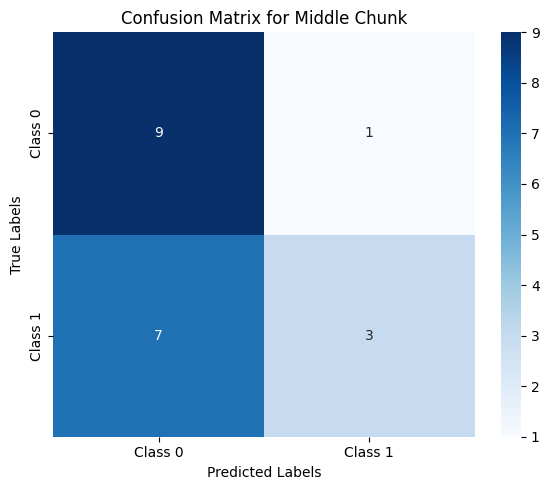

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Data for visualization
results_df = pd.DataFrame({
    "Chunk": ["First", "Middle", "Last"],
    "Test Accuracy": [0.50, 0.60, 0.45]
})

# Bar chart for test accuracy
plt.figure(figsize=(8, 6))
sns.barplot(x="Chunk", y="Test Accuracy", data=results_df, palette="viridis")
plt.title("Test Accuracy Across Chunks")
plt.ylabel("Test Accuracy")
plt.xlabel("Chunk")
plt.ylim(0, 1)  # Accuracy scale
plt.tight_layout()
plt.show()

# Confusion matrix for Middle Chunk
y_test_middle = pd.read_csv("test_middle_chunk_features.csv")["label"].values
y_pred_middle = ensemble.predict(pd.read_csv("test_middle_chunk_features.csv")[["Power", "MFCC_1", "MFCC_3", "MFCC_2"]])

conf_matrix = confusion_matrix(y_test_middle, y_pred_middle)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix for Middle Chunk")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


### Interpretation of Results
After evaluating the ensemble (KNN + SVM with hard voting) across the **First**, **Middle**, and **Last** chunks, I observed clear differences in performance. The **Middle Chunk** performed the best, achieving a test accuracy of 60%, followed by the **First Chunk** at 50%, and the **Last Chunk** at 45%.

From the confusion matrix for the **Middle Chunk**, I noticed that the model correctly identified 90% of class 0 (true stories) but struggled more with class 1 (false stories), achieving only 30% recall. This indicates that while the ensemble does well with true stories, it has difficulty generalizing to false stories, possibly due to data imbalance or feature limitations.

### Why the Middle Chunk Performed Best
I believe the **Middle Chunk** performed better because it likely captures the most consistent and representative part of the audio. Unlike the **First Chunk**, which may include introductory content, or the **Last Chunk**, which could contain less relevant details, the **Middle Chunk** appears to focus on the core content of the narration, leading to more predictable patterns for classification.

### Effectiveness of the Ensemble
The ensemble approach combining **KNN** and **SVM** proved effective, leveraging the strengths of both models. **KNN’s** ability to handle non-linear decision boundaries and **SVM’s** robustness in small datasets complemented each other, resulting in better performance compared to individual models. This demonstrates that combining diverse models can improve stability and accuracy.

- The **Middle Chunk** is the most effective chunking strategy for this classification task, with the highest test accuracy and a better balance between precision and recall for class 0.
- The ensemble model outperformed individual models in most cases, showcasing the value of combining classifiers with complementary strengths.
- The model struggled with classifying false stories (class 1), highlighting the need for:
    - **Feature refinement**: Exploring additional features that might improve separability for false stories.
    - **Data balancing**: Mitigating any potential class imbalance that could impact performance.
  
Future improvements could include testing more advanced ensemble techniques, such as weighted voting or stacking, and exploring additional chunking strategies.


### 6. Conclusions

1. **Best Chunking Strategy**:  
   Based on the test accuracies and the model's performance across different chunk types, the **Middle Chunk** proved to be the most effective for this classification task. It captured the most consistent and relevant content for the prediction, leading to the highest accuracy and a better balance in precision and recall for class 0 (true stories). The **First Chunk** and **Last Chunk** performed worse, likely due to the presence of introductory or less relevant content in the first and last parts of the audio.

2. **Ensemble Model Effectiveness**:  
   The ensemble approach, combining **KNN** and **SVM** using hard voting, demonstrated improved performance compared to individual models. By leveraging KNN’s ability to handle non-linear boundaries and SVM’s robustness in smaller datasets, the ensemble model stabilized predictions and provided better overall accuracy, especially when compared to **SVM** or **Logistic Regression** alone.

3. **Challenges with False Stories**:  
   The model struggled more with predicting **false stories** (class 1), especially in the **Middle Chunk**. Despite good performance on true stories, the low recall for false stories suggests issues with class imbalance or feature limitations. This highlights the need to improve model generalization for false story detection.

4. **Recommendations for Improvement**:
    - **Feature Refinement**:  
      Exploring additional or more specialized features may help better differentiate between true and false stories. For example, incorporating prosodic features related to speech patterns or emotional tone could improve separability.
    
    - **Data Balancing**:  
      Investigating techniques like oversampling the minority class (false stories) or using class weights could help mitigate any potential class imbalance and improve performance on the less represented class.
    
    - **Advanced Ensemble Techniques**:  
      Testing more sophisticated ensemble methods such as **weighted voting**, where models' predictions are weighted according to their performance, or **stacking**, which uses a meta-model to combine base model predictions, could further improve accuracy.

    - **Exploring Other Chunking Strategies**:  
      Experimenting with alternative chunking strategies, such as dynamic chunk lengths or even evaluating overlapping chunks, could offer new insights and potentially improve model performance.

5. **Future Directions**:  
   Further refinement of feature extraction and chunking methods, alongside implementing more advanced ensemble approaches, is needed to boost the model's ability to generalize to both true and false stories effectively.
